# Semantic Analysis with NLP

### Name: Davi BARRETO FAÇANHA

## Import libraries

In [1]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd ## manip dataframe
import numpy as np ## opérations sur vecteurs
import matplotlib.pyplot as plt  ## visualisation
import re ### regular expressions

from gensim.models import Word2Vec, Phrases ## Pour entrainer le modèle word2vec 

from wordcloud import WordCloud ## nuage de mots

import nltk ## traitement sur le texte

nltk.download('punkt') ## nltk tokenizer requiert punkt package
from nltk import word_tokenize ## fonction pour tockenizer

nltk.download('stopwords')## nltk corpus requiert punkt package
from nltk.corpus import stopwords ##  stopwords dans différentes langues

nltk.download('wordnet') ## nltk stem requiert punkt package
from nltk.stem import WordNetLemmatizer #

from collections import defaultdict  # For word frequency

[nltk_data] Downloading package punkt to /home/davi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/davi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/davi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## I) Exploration des données

### 1) Importer les jeux de données « labeledTrainData» et « unlabeledTrainData».

In [2]:
# Read data from files
cols = ['sentiment', 'review']

df_train = pd.read_csv('labeledTrainData.tsv', sep='\t')

df_test  = pd.read_csv('unlabeledTrainData.tsv', error_bad_lines=False, sep='\t')

b'Skipping line 43043: expected 2 fields, saw 3\n'


#### Eliminer les reviews nuls

In [3]:
df_train = df_train[~df_train['review'].isnull()]
df_test = df_test[~df_test['review'].isnull()]

In [4]:
df_test.head()

,id,review
0,9999_0,"Watching Time Chasers, it obvious that it was ..."
1,45057_0,I saw this film about 20 years ago and remembe...
2,15561_0,"Minor Spoilers<br /><br />In New York, Joan Ba..."
3,7161_0,I went to see this film with a great deal of e...
4,43971_0,"Yes, I agree with everyone on this site this m..."


In [5]:
df_train.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [6]:
datasets = [df_train,  df_test]
titles = ['Train data',  'Unlabeled train data']
for dataset, title in zip(datasets,titles):
    print(title)
    dataset.info()
    display(dataset.head())

Train data
<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         25000 non-null  object
 1   sentiment  25000 non-null  int64 
 2   review     25000 non-null  object
dtypes: int64(1), object(2)
memory usage: 781.2+ KB


,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


Unlabeled train data
<class 'pandas.core.frame.DataFrame'>
Int64Index: 49998 entries, 0 to 49997
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      49998 non-null  object
 1   review  49998 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


,id,review
0,9999_0,"Watching Time Chasers, it obvious that it was ..."
1,45057_0,I saw this film about 20 years ago and remembe...
2,15561_0,"Minor Spoilers<br /><br />In New York, Joan Ba..."
3,7161_0,I went to see this film with a great deal of e...
4,43971_0,"Yes, I agree with everyone on this site this m..."


#### 50/50 pour les sentiments

In [7]:
df_train.sentiment.value_counts()

1    12500
0    12500
Name: sentiment, dtype: int64

#### Thus, the train data is balanced. Which means we can go foward into the words treatment.

In [8]:
### Extract positive and negative reviews
df_train_pos = df_train.loc[df_train['sentiment']==1]
df_train_neg = df_train.loc[df_train['sentiment']==0]

pos_txt = ' '.join(list(df_train_pos.review))
neg_txt = ' '.join(list(df_train_neg.review))

### 2) Afficher le nuage de mots (word cloud) associé au ‘reviews’ en utilisant librairie wordcloud.

 - Utiliser la fonction WordCloud de la librairie wordcloud.
         conda install -c conda-forge wordcloud (installation de la fonction wordcloud)

#### With this approach, we can have a "big picture" view of the most influential words.

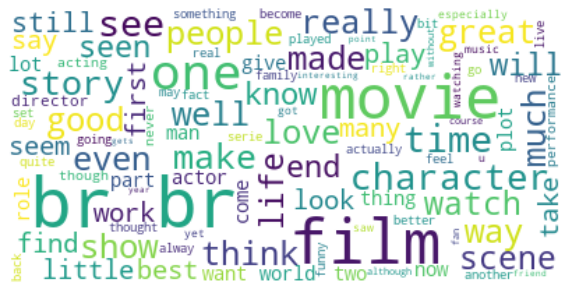

In [9]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(pos_txt)
plt.figure(figsize=(10, 20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

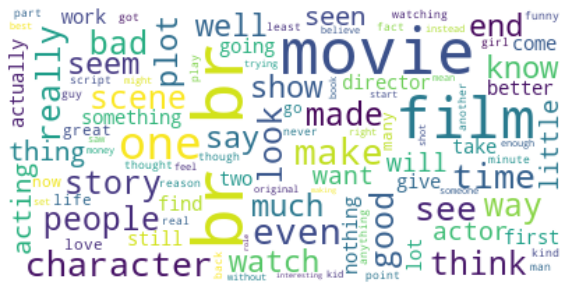

In [10]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(neg_txt)
plt.figure(figsize=(10, 20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

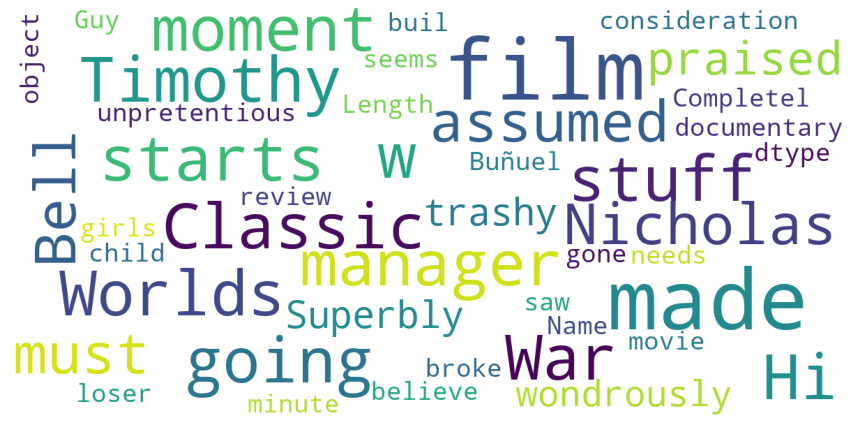

In [11]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
 
def show_wordcloud(data, title = ""):
    wordcloud = WordCloud(background_color='white',
                          max_words=500,
                          max_font_size=40,
                          scale=3,
                          random_state=1 # chosen at random by flipping a coin; it was heads
                         ).generate(str(data))
    
    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
        
    plt.imshow(wordcloud)
    plt.show()
        
show_wordcloud(data=df_train['review'])

## 2) Entraînement du modèle Word2Vec

### 1) Pre-processing de données

#### For the pre-processing, we're gonna do some functions to makes it easier. 

- La fonction clean_txt: permet de supprimer les chiffres, caractères spéciaux... *) la fonction remove_stop_words: permet de supprimer les mots inutiles

In [12]:
def clean_review(raw_review: str) -> str:
    raw_review = raw_review.replace('<br />', '')
    raw_review = re.sub('[^A-Za-z]+', ' ', raw_review)
    raw_review = raw_review.lstrip()\
    .rstrip()\
    .lower()
    
    return raw_review

- La fonction tokenization: permet de transformer le corpus en liste de mots

In [13]:
def tokenization(text):
    return  word_tokenize(text)

- La fonction remove_stop_words: permet de supprimer les mots inutiles

In [14]:
stop_words = stopwords.words('english')
def remove_stop_words(tokens: list) -> list :
    return list(filter(lambda x : not x in stop_words, tokens))

 - La fonction lemmatization : utiliser WordNetLemmatizer afin de faire la lemmatization des mots

In [15]:
lemmatizer = WordNetLemmatizer()
def lemmatize(tokens: list) -> list:
    # 1. Lemmatize
    lemmatized_tokens = list(map(lambda x: lemmatizer.lemmatize(x, "v"), tokens))
    return lemmatized_tokens


 - La fonction preprocess : regroupe les fonctions précédentes

In [16]:
def preprocess(review: str, total: int, show_progress: bool = True) -> list:
    if show_progress:
        global counter
        counter += 1
        print('Processing... %6i/%6i'% (counter, total), end='\r')
    # 1. Clean text
    review = clean_review(review)
    # 2. Split into individual words
    tokens = word_tokenize(review)
    # 3. Remove stopwords
    filtered_tokens = remove_stop_words(tokens)
    # 4. Lemmatize
    lemmas = lemmatize(filtered_tokens)
    # 5. Join the words back into one string separated by space,
    # and return the result.
    return lemmas

### 2) Appliquer la fonction preprocess à toutes les reviews (train + test). Puis, afficher le nuage de mots associés aux ‘reviews’

In [17]:
all_reviews = np.array([], dtype=str)
for dataset in datasets:
    all_reviews = np.concatenate((all_reviews, dataset.review), axis=0)
print('Total number of reviews:', len(all_reviews))

Total number of reviews: 74998


In [18]:
counter = 0
all_reviews = np.array(list(map(lambda x: preprocess(x, len(all_reviews)), all_reviews)))

In [19]:
reviews_train = np.array(list(map(lambda x: preprocess(x, len(df_train.review)), df_train.review)))

In [20]:
counter = 0
reviews_test = np.array(list(map(lambda x: preprocess(x, len(df_test.review)), df_test.review)))

### 3) Instancier le modèle Phrases de gensim avec les reviews, afin de créer un modèle bigram_transformer qui détecter et regrouper les mots-composés dans les reviews.

In [21]:
## Détecter et les phrases
bigram_transformer = Phrases(all_reviews)

In [22]:
bigram_transformer[all_reviews[0]]

['stuff',
 'go',
 'moment',
 'mj',
 'start',
 'listen',
 'music',
 'watch',
 'odd',
 'documentary',
 'watch',
 'wiz',
 'watch',
 'moonwalker',
 'maybe',
 'want',
 'get',
 'certain',
 'insight',
 'guy',
 'think',
 'really',
 'cool',
 'eighties',
 'maybe',
 'make',
 'mind',
 'whether',
 'guilty_innocent',
 'moonwalker',
 'part',
 'biography',
 'part',
 'feature',
 'film',
 'remember',
 'go',
 'see',
 'cinema',
 'originally_release',
 'subtle_message',
 'mj',
 'feel',
 'towards',
 'press',
 'also',
 'obvious',
 'message',
 'drug',
 'bad',
 'kay',
 'visually',
 'impressive',
 'course',
 'michael_jackson',
 'unless',
 'remotely',
 'like',
 'mj',
 'anyway',
 'go',
 'hate',
 'find',
 'bore',
 'may',
 'call',
 'mj',
 'egotist',
 'consent',
 'make',
 'movie',
 'mj',
 'fan',
 'would',
 'say',
 'make',
 'fan',
 'true',
 'really',
 'nice',
 'actual',
 'feature',
 'film',
 'bite',
 'finally',
 'start',
 'minutes',
 'exclude',
 'smooth_criminal',
 'sequence',
 'joe_pesci',
 'convince',
 'psychopathi

In [23]:
print(bigram_transformer['new york near the solar '.split()])

['new_york', 'near', 'the', 'solar']


### 4) Entraînement du modèle Word2Vec avec la taille du embedding_vector = 300

In [34]:
## Docs : https://www.kite.com/python/docs/gensim.models.word2vec

# Creating the model and setting values for the various parameters
num_features = 300  # Word vector dimensionality
min_word_count = 40 # Minimum word count
num_workers = 4     # Number of parallel threads
context = 10        # Context window size

In [32]:
# Initializing the train model
from gensim.models import word2vec
print("Training model....")
model = word2vec.Word2Vec(sentences = bigram_transformer[all_reviews],
                          workers=num_workers,
                          size=num_features,
                          min_count=min_word_count,
                          window=context)

# To make the model memory efficient
#model.init_sims(replace=True)

# Saving the model for later use. Can be loaded using Word2Vec.load()
model_name = "300features_40minwords_10context"
model.save(model_name)

Training model....


In [24]:
# Load the already trained model, if necessary
model = Word2Vec.load("300features_40minwords_10context")

In [25]:
embedding_vector_size = 256

bigrams_model = Word2Vec(
    sentences = bigram_transformer[all_reviews],
    size = embedding_vector_size,
    min_count=3, window=5, workers=4)

## Visualidation des vecteurs de mots

In [26]:
word_vectors = pd.DataFrame(model.wv.vectors, index=model.wv.index2word)
print('word vector dimension: ', word_vectors.shape)
word_vectors.head()

word vector dimension:  (15606, 300)


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
film,-0.109312,0.633502,-0.134283,0.010018,-0.128073,-0.797416,0.358856,-0.199442,-0.364621,1.252105,...,0.300597,-0.196111,-0.689066,-0.002817,0.032588,-0.343646,-1.104487,0.604697,0.461858,0.218632
movie,-0.393068,0.148960,1.104141,-0.261139,-0.394184,0.155927,0.208264,-0.867991,0.341332,-0.733110,...,-0.431863,0.073480,-1.384334,0.431550,1.384255,-1.006732,-1.076986,0.844770,0.830270,-0.007477
one,0.799321,0.308866,1.222796,-1.212842,0.020086,-0.735051,-0.319416,-0.236541,0.642293,0.130994,...,-0.041106,0.337762,0.872454,0.629773,0.801912,-1.036854,0.040323,-1.731413,0.175932,1.026595
make,-0.111099,1.184408,0.035146,-1.136476,0.635911,0.070731,-0.851914,-0.689996,0.328527,-1.707414,...,0.933830,-0.171050,0.503484,-0.369065,0.670671,-0.986399,0.422988,-0.519989,0.585233,-1.004478
like,-0.924244,0.068925,0.260206,-0.352292,-0.171694,1.024178,-0.532671,-0.260713,0.696467,-1.734606,...,0.207129,-0.477607,1.065707,0.709137,-0.106123,-0.669179,-0.344840,0.456847,0.867688,-0.288497


### 5) Questions

 - Trouver le degré de similarité entre : **"data" et "statistic", "peace" et"art"**

In [27]:
print(" Similarity between Data and Information: ", model.wv.similarity('data', 'information'))
print("\n Similarity between Movie and Film: ", model.wv.similarity('movie', 'film'))
print("\n Similarity between Peace and Art: ", model.wv.similarity('peace', 'art'))

 Similarity between Data and Information:  0.72205377

 Similarity between Movie and Film:  0.4504705

 Similarity between Peace and Art:  0.21858884


 - Trouver les mots les plus similiaires aux mots suivants : **"titanic", "actor", "cat"**

In [28]:
print("---------------- List of most similar words ---------------- ")
print("\n> Titanic : \n",model.wv.most_similar('titanic')[:3])
print("------------------------------------------------------------")
print("\n> Actor : \n",model.wv.most_similar('actor')[:3])
print("------------------------------------------------------------")
print("\n> Cat : \n",model.wv.most_similar('cat')[:3])

---------------- List of most similar words ---------------- 

> Titanic : 
 [('jam_cameron', 0.6339555978775024), ('voyage', 0.6266962885856628), ('apocalypse', 0.6097408533096313)]
------------------------------------------------------------

> Actor : 
 [('lead_role', 0.6728414297103882), ('actress', 0.6669633984565735), ('actors', 0.6633502244949341)]
------------------------------------------------------------

> Cat : 
 [('mice', 0.7740564346313477), ('rabbit', 0.7476157546043396), ('mouse', 0.739993691444397)]


 - Trouver les intrus : **"man woman dog child kitchen", "france england germany berlin"**

In [29]:
print("Finding the wrong word among the other ----")
print("    > The wrong word for the 1st case: ", model.wv.doesnt_match('man woman dog child kitchen'.split()))
print("    > The wrong word for the 2nd case:", model.wv.doesnt_match('france england germany berlin'.split()))

Finding the wrong word among the other ----
    > The wrong word for the 1st case:  kitchen
    > The wrong word for the 2nd case: berlin


 - Trouver le résultat des opérations suivantes :  **man+princess-woman = ?**

In [30]:
print("The semantic equation has the following result: \n", model.wv.most_similar(positive=['man','princess'],negative=['woman'],topn=1)) 

The semantic equation has the following result: 
 [('abu', 0.6537904739379883)]


On peut aussi utiliser des modèles pré-entrainés

- **Google’s Word2Vec Embedding**

In [8]:
## télécharger  ici https://github.com/mmihaltz/word2vec-GoogleNews-vectors

In [9]:
from gensim.models import KeyedVectors
filename = 'GoogleNews-vectors-negative300.bin.gz'
model = KeyedVectors.load_word2vec_format(filename, binary=True)

- **Stanford’s GloVe Embedding**

In [135]:
## télécharger  https://nlp.stanford.edu/projects/glove/

In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = 'glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)
from gensim.models import KeyedVectors
# load the Stanford GloVe model
filename = 'glove.6B.100d.txt.word2vec'
model = KeyedVectors.load_word2vec_format(filename, binary=False)

#### 6) Aggrégation des vecteurs de mots

L'idée est d'agréger l'ensemble des vecteurs de mots présents dans un document

In [35]:
def aggregate_vector_model(words, model, num_features):
    # Pre-initialising empty numpy array for speed
    featureVec = np.zeros(num_features,dtype="float32")
    nwords = 0
    
    #Converting Index2Word which is a list to a set for better speed in the execution.
    index2word_set = set(model.wv.index2word)
    
    for word in  words:
        if word in index2word_set:
            nwords = nwords + 1
            featureVec = np.add(featureVec,model[word]) ## add word vectors element by element
    
    # Dividing the result by number of words to get average
    featureVec = np.divide(featureVec, nwords)
    return featureVec

In [36]:
# Function for calculating the average feature vector
def getAverage_vector_model(reviews, model, num_features):
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        # Printing a status message every 1000th review
        if counter%1000 == 0:
            print("Review %d of %d"%(counter,len(reviews)))
            
        reviewFeatureVecs[counter] = aggregate_vector_model(review, model, num_features) ## apply featureVecMethod to each review to get an average word vector
        
        counter = counter+1
        
    return reviewFeatureVecs

- Cacul des vecteurs moyens sur la base df_train

In [37]:
data_train_vect = getAverage_vector_model(reviews_train, model, num_features)

Review 0 of 25000
Review 1000 of 25000
Review 2000 of 25000
Review 3000 of 25000
Review 4000 of 25000
Review 5000 of 25000
Review 6000 of 25000
Review 7000 of 25000
Review 8000 of 25000
Review 9000 of 25000
Review 10000 of 25000
Review 11000 of 25000
Review 12000 of 25000
Review 13000 of 25000
Review 14000 of 25000
Review 15000 of 25000
Review 16000 of 25000
Review 17000 of 25000
Review 18000 of 25000
Review 19000 of 25000
Review 20000 of 25000
Review 21000 of 25000
Review 22000 of 25000
Review 23000 of 25000
Review 24000 of 25000


- Cacul des vecteurs moyens sur la base df_test

In [38]:
data_test_vect = getAverage_vector_model(reviews_test, model, num_features)

Review 0 of 49998
Review 1000 of 49998
Review 2000 of 49998
Review 3000 of 49998
Review 4000 of 49998
Review 5000 of 49998
Review 6000 of 49998
Review 7000 of 49998
Review 8000 of 49998
Review 9000 of 49998
Review 10000 of 49998
Review 11000 of 49998
Review 12000 of 49998
Review 13000 of 49998
Review 14000 of 49998
Review 15000 of 49998
Review 16000 of 49998
Review 17000 of 49998
Review 18000 of 49998
Review 19000 of 49998
Review 20000 of 49998
Review 21000 of 49998
Review 22000 of 49998
Review 23000 of 49998
Review 24000 of 49998
Review 25000 of 49998
Review 26000 of 49998
Review 27000 of 49998
Review 28000 of 49998
Review 29000 of 49998
Review 30000 of 49998
Review 31000 of 49998
Review 32000 of 49998
Review 33000 of 49998
Review 34000 of 49998
Review 35000 of 49998
Review 36000 of 49998
Review 37000 of 49998
Review 38000 of 49998
Review 39000 of 49998
Review 40000 of 49998
Review 41000 of 49998
Review 42000 of 49998
Review 43000 of 49998
Review 44000 of 49998
Review 45000 of 49998
R

### 7) Modélisation : mise en oeuvre d'un modèle d'analyse de sentiment

#### Random Forest

In [39]:
# Fitting a random forest classifier to the training data
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 50)
data_train_vect = np.nan_to_num(data_train_vect)
print("Fitting random forest to training data....")    
forest = forest.fit(data_train_vect, df_train["sentiment"])

Fitting random forest to training data....


In [40]:
# Predicting the sentiment values for test data and saving the results in a csv file 
data_test_vect = np.nan_to_num(data_test_vect)
result = forest.predict(data_test_vect)
output = pd.DataFrame(data={"id":df_test["id"], "review":df_test["review"], "sentiment":result})


In [41]:
output['review'].iloc[0]

'Watching Time Chasers, it obvious that it was made by a bunch of friends. Maybe they were sitting around one day in film school and said, \\Hey, let\'s pool our money together and make a really bad movie!\\" Or something like that. What ever they said, they still ended up making a really bad movie--dull story, bad script, lame acting, poor cinematography, bottom of the barrel stock music, etc. All corners were cut, except the one that would have prevented this film\'s release. Life\'s like that."'

### Single Layer Perceptron 

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout 

In [44]:
y_train = np.array( df_train["sentiment"])

model = Sequential()
model.add(Dense(32, activation='relu', input_dim=300))
model.add(Dense(1, activation='sigmoid')) ## softmax si multiclasse
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(data_train_vect, y_train, epochs=50, batch_size=32, verbose=2)

Epoch 1/50
782/782 - 1s - loss: 0.3414 - accuracy: 0.8591
Epoch 2/50
782/782 - 1s - loss: 0.3114 - accuracy: 0.8720
Epoch 3/50
782/782 - 1s - loss: 0.3060 - accuracy: 0.8737
Epoch 4/50
782/782 - 1s - loss: 0.3023 - accuracy: 0.8762
Epoch 5/50
782/782 - 1s - loss: 0.2987 - accuracy: 0.8762
Epoch 6/50
782/782 - 1s - loss: 0.2964 - accuracy: 0.8797
Epoch 7/50
782/782 - 1s - loss: 0.2932 - accuracy: 0.8796
Epoch 8/50
782/782 - 1s - loss: 0.2908 - accuracy: 0.8822
Epoch 9/50
782/782 - 1s - loss: 0.2884 - accuracy: 0.8820
Epoch 10/50
782/782 - 1s - loss: 0.2865 - accuracy: 0.8830
Epoch 11/50
782/782 - 1s - loss: 0.2844 - accuracy: 0.8839
Epoch 12/50
782/782 - 1s - loss: 0.2824 - accuracy: 0.8848
Epoch 13/50
782/782 - 1s - loss: 0.2807 - accuracy: 0.8853
Epoch 14/50
782/782 - 1s - loss: 0.2789 - accuracy: 0.8863
Epoch 15/50
782/782 - 1s - loss: 0.2766 - accuracy: 0.8874
Epoch 16/50
782/782 - 1s - loss: 0.2753 - accuracy: 0.8874
Epoch 17/50
782/782 - 1s - loss: 0.2730 - accuracy: 0.8899
Epoch 

#### Prédiction sur des nouvelles revues

In [45]:
result= model.predict_classes(data_test_vect)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [46]:
## convertir result en list

In [47]:
result = [result[i].item() for i in range(0, len(result))]

In [48]:

output = pd.DataFrame(data={"id":df_test["id"], "review":df_test["review"], "sentiment":result})


In [49]:
countone=0
countzero=0
for i,j in enumerate(result):
    if result[i]==0:
        countzero += 1
    if result[i]==1:
        countone +=1
        
Positive_Tweets =(countone/len(result))*100
Negative_Tweets =(countzero/len(result))*100
print('Positive Tweets %: ',Positive_Tweets)
print('Negative Tweets %: ',Negative_Tweets)

Positive Tweets %:  49.21996879875195
Negative Tweets %:  50.78003120124806


#### Visualisation des sentiments

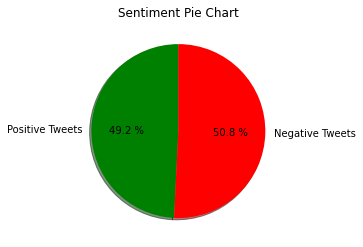

In [50]:
plt.pie([Positive_Tweets,Negative_Tweets ],
        labels=['Positive Tweets','Negative Tweets'],
        colors=['g','r'],
        startangle=90,
        shadow= True,
        autopct='%1.1f %%')
plt.title('Sentiment Pie Chart')
plt.savefig(' sentiment')